In [1]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            # Creates 'world height number of list' and each list has 'world width number of elements'
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos) #Copy the object at that point in time
            self.last_box_pos = copy.deepcopy(self.box_pos)
            # Every element of 'world' becomes '_'
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                # Raises an error: "A[1] != B[1]" if A[1] == B[1] is not True as we can see from above,
                # all of the tuples has the same 2nd number in each list
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER # Trying to replace the values in World Grid to the variables defined on top
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)

        # If the agent and box does not accupy the same space at 1 time, update new position as current position
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info



    def step_sparseReward(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)

        # If the agent and box does not accupy the same space at 1 time, update new position as current position
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1

        reward = 0  # Default reward is set to 0

        # If the agent reaches the goal, provide a positive sparse reward
        if all(self.box_pos == self.goal_pos):
            reward = 1000
            done = True

        # Penalty for falling off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward = -1000
            done = True

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info


    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """

        # Do not allow box or agent's position to be outside World Grid
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        # Additional constraints to ensure box is not touching the edge of the World
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

The learn() method of the following class to implement the RL algorithm:

In [9]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space
        self.q_table = dict() # Store all Q-values in a dictionary
        # Loop through all possible grid spaces, create sub-dictionary for each
        for agent_x in range(env.world_height):
            for agent_y in range(env.world_width):
                for box_x in range(env.world_height):
                    for box_y in range(env.world_width):
                        # Populate sub-dictionary with zero values for possible moves
                        self.q_table[(agent_x, agent_y, box_x, box_y)] = {k: 0 for k in self.action_space}

        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha # Learning Rate
        self.gamma = gamma # Discount Factor

    def act(self, state):
        """Returns the (epsilon-greedy) optimal action from Q-Value table."""
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            q_values_of_state = self.q_table[state]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])

        return action

    def update_q_table(self, state, action, reward, next_state,RLName):
        q_max=0
        if(RLName=="QLearning"):
            if next_state is not None:
                q_max=max(self.q_table[next_state].values())
            self.q_table[state][action] = self.q_table[state][action] + self.alpha * (reward + self.gamma * q_max - self.q_table[state][action])
        else:
            next_action=self.act(next_state)
            self.q_table[state][action] = self.q_table[state][action] + self.alpha * (reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action])

    def update_q_table_noExploration(self, state, action, reward, next_state,RLName):
        q_max=0
        if(RLName=="QLearning"):
            if next_state is not None:
                q_max=max(self.q_table[next_state].values())
            self.q_table[state][action] = self.q_table[state][action] + self.alpha * (reward + self.gamma * q_max - self.q_table[state][action])
        else:
            next_action=self.act_noExploration(next_state)
            self.q_table[state][action] = self.q_table[state][action] + self.alpha * (reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action])



    def learn(self,RLName):
        """Updates Q-values iteratively."""
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                #raise NotImplementedError
                # TODO: Update Q-values
                actionTaken=self.act(state) # Exploit learned values

                stateNew, reward, done, info=self.env.step(actionTaken)
                self.update_q_table(state, actionTaken , reward, stateNew,RLName)
                state = stateNew
                cumulative_reward += reward
            rewards.append(cumulative_reward)

        return rewards

    def learn_sparseReward(self,RLName):
        """Updates Q-values iteratively."""
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                #raise NotImplementedError
                # TODO: Update Q-values
                actionTaken=self.act(state) # Exploit learned values

                stateNew, reward, done, info=self.env.step_sparseReward(actionTaken)
                self.update_q_table(state, actionTaken , reward, stateNew,RLName)
                state = stateNew
                cumulative_reward += reward
            rewards.append(cumulative_reward)

        return rewards

    def act_noExploration(self, state):
        """Returns the greedy optimal action from Q-Value table without exploration."""
        q_values_of_state = self.q_table[state]
        maxValue = max(q_values_of_state.values())
        action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        return action

    def learn_noExploration(self,RLName):
        """Updates Q-values iteratively."""
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0 # Initialise values of each game
            state = self.env.reset()
            done = False
            while not done: # Run until game terminated
                #raise NotImplementedError
                # TODO: Update Q-values
                actionTaken=self.act_noExploration(state) # Exploit learned values

                stateNew, reward, done, info=self.env.step(actionTaken)
                self.update_q_table_noExploration(state, actionTaken , reward, stateNew,RLName)
                state = stateNew
                cumulative_reward += reward
            rewards.append(cumulative_reward)

        return rewards

From the below, we can see that the same Learning Rate (alpa), Exploration-Exploitation parameter (epsilon) and Discount Factor (gamma) leads to different return results in different Reinforcement Learning algorithms

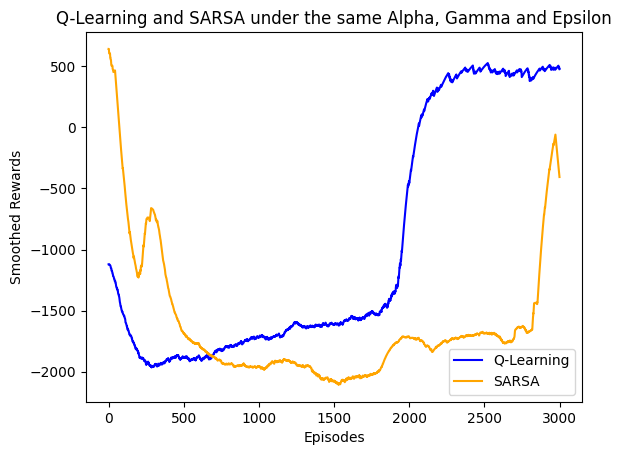

In [66]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=3000,epsilon=0.01, alpha=0.5, gamma=0.99)
rewardsQL = agent.learn("QLearning")
rewardsSARSA = agent.learn("SARSA")
# Smooth plot Q-Learning
weight = 0.99
lastQL = rewardsQL[0]
smoothedQL = []
for v in rewardsQL:
    smoothed_val = lastQL * weight + (1 - weight) * v
    smoothedQL.append(smoothed_val)
    lastQL = smoothed_val

# Plot the learning curve for Q-Learning
plt.plot(smoothedQL, label='Q-Learning', color='blue')

# Smooth plot SARSA
lastSARSA = rewardsSARSA[0]
smoothedSARSA = []
for v in rewardsSARSA:
    smoothed_val = lastSARSA * weight + (1 - weight) * v
    smoothedSARSA.append(smoothed_val)
    lastSARSA = smoothed_val

# Plot the learning curve for SARSA
plt.plot(smoothedSARSA, label='SARSA', color='orange')

# Add labels and legend
plt.xlabel('Episodes')
plt.ylabel('Smoothed Rewards')
plt.title('Q-Learning and SARSA under the same Alpha, Gamma and Epsilon')
plt.legend()

# Show the plot
plt.show()


The below shows the graphs where there epsilon is 0 for both SARSA and Q-Learning. Epsilon being 0 meant that there is no exploration done to the action space and that the approach is completely greedy.

We can see that while trying to increase the alpha from 0.9 to 0.99, while there is a faster increase in rewards when using alpha = 0.99, there is not increase in the maximum reward from both algorithms.

The maximum returns for
alpha = 0.8: 642   episode: 1422
alpha = 0.9: 642   episode: 1346
alpha = 0.99: 642   episode: 1295


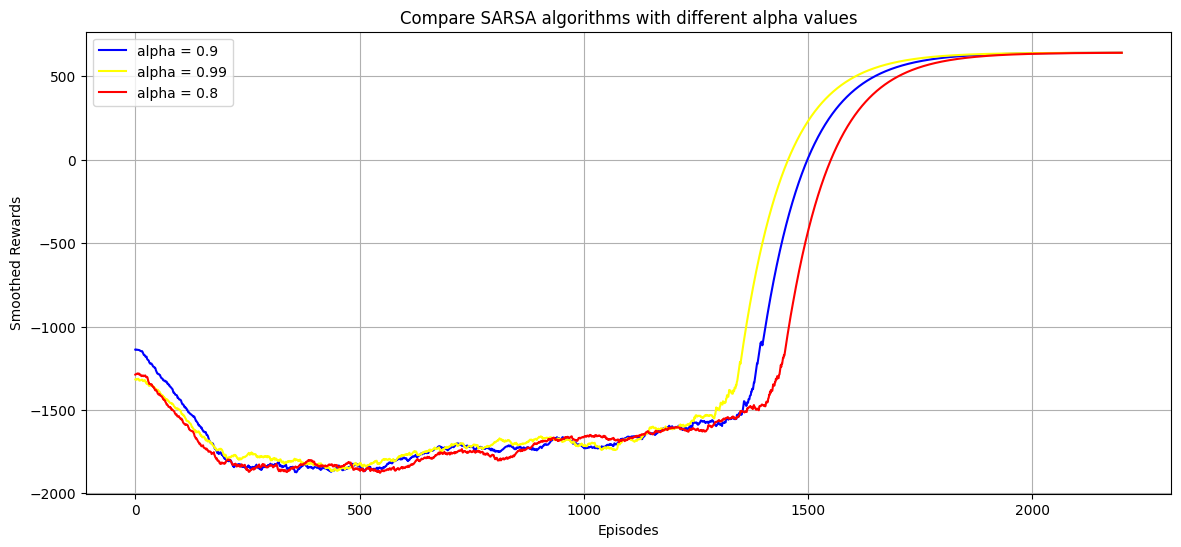

In [67]:
def main():
  env = CliffBoxGridWorld()
  agent1 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.9, gamma=0.99)
  rewardsSARSA1 = agent1.learn("SARSA")
  agent2 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.99, gamma=0.99)
  rewardsSARSA2 = agent2.learn("SARSA")
  agent3 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.8, gamma=0.99)
  rewardsSARSA3 = agent3.learn("SARSA")
  print(f"The maximum returns for\nalpha = 0.8: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nalpha = 0.9: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nalpha = 0.99: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA alpha=0.9
  plt.plot(plotgraph(weight,rewardsSARSA1), label='alpha = 0.9', color='blue')

  # Plot SARSA alpha=0.99
  plt.plot(plotgraph(weight,rewardsSARSA2), label='alpha = 0.99', color='yellow')

  # Plot SARSA alpha=0.8
  plt.plot(plotgraph(weight,rewardsSARSA3), label='alpha = 0.8', color='red')

  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare SARSA algorithms with different alpha values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()



def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed


main()


Taking the analysis of alpha values further, we now increase the value of alpha to as large as possible since in the previous graph, we see that larger alpha values allow us to reach teh maximum return in fewer episodes.

As seen from the graph below, we see that alpha the graoph with alpha=0.99 increase its cummulative return slower, it reached the maximum return in the least episodes.

The maximum returns for
alpha = 1.0: 642   episode: 1215
alpha = 1.0: 642   episode: 1263
alpha = 0.9999999999999999: 642   episode: 1215
alpha = 0.9999999999999994: 642   episode: 1283
alpha = 0.999999999999999: 642   episode: 1258


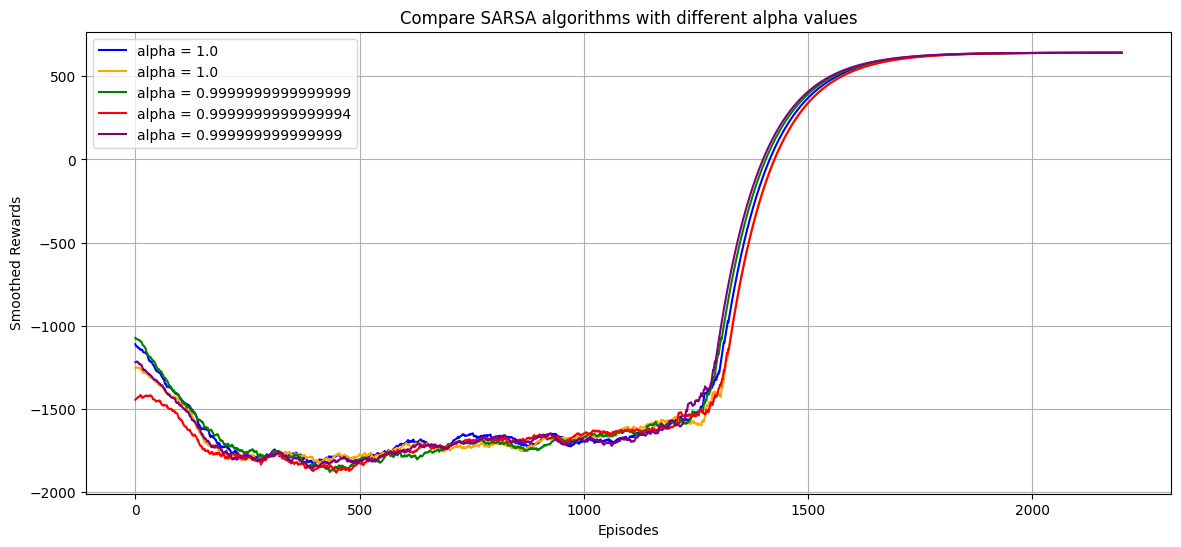

In [85]:
def main():
  env = CliffBoxGridWorld()
  alpha1=0.99999999999999999
  alpha2=0.99999999999999995
  alpha3=0.9999999999999999
  alpha4=0.9999999999999994
  alpha5=0.999999999999999
  agent1 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=alpha1, gamma=0.99)
  rewardsSARSA1 = agent1.learn("SARSA")
  agent2 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=alpha2, gamma=0.99)
  rewardsSARSA2 = agent2.learn("SARSA")
  agent3 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=alpha3, gamma=0.99)
  rewardsSARSA3 = agent3.learn("SARSA")
  agent4 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=alpha4, gamma=0.99)
  rewardsSARSA4 = agent4.learn("SARSA")
  agent5 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=alpha5, gamma=0.99)
  rewardsSARSA5 = agent5.learn("SARSA")
  print(f"The maximum returns for\nalpha = {alpha1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nalpha = {alpha2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nalpha = {alpha3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nalpha = {alpha4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nalpha = {alpha5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'alpha = {alpha1}', color='blue')

  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'alpha = {alpha2}', color='orange')

  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'alpha = {alpha3}', color='green')

  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'alpha = {alpha4}', color='red')

  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'alpha = {alpha5}', color='purple')

  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare SARSA algorithms with different alpha values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()



def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed


main()

We now analyse the change in gamma values.

The maximum returns for
gamma = 0.9999999: 642   episode: 1327
gamma = 0.99: 642   episode: 1273
gamma = 0.8: -1039   episode: 3
gamma = 0.7: -1076   episode: 22


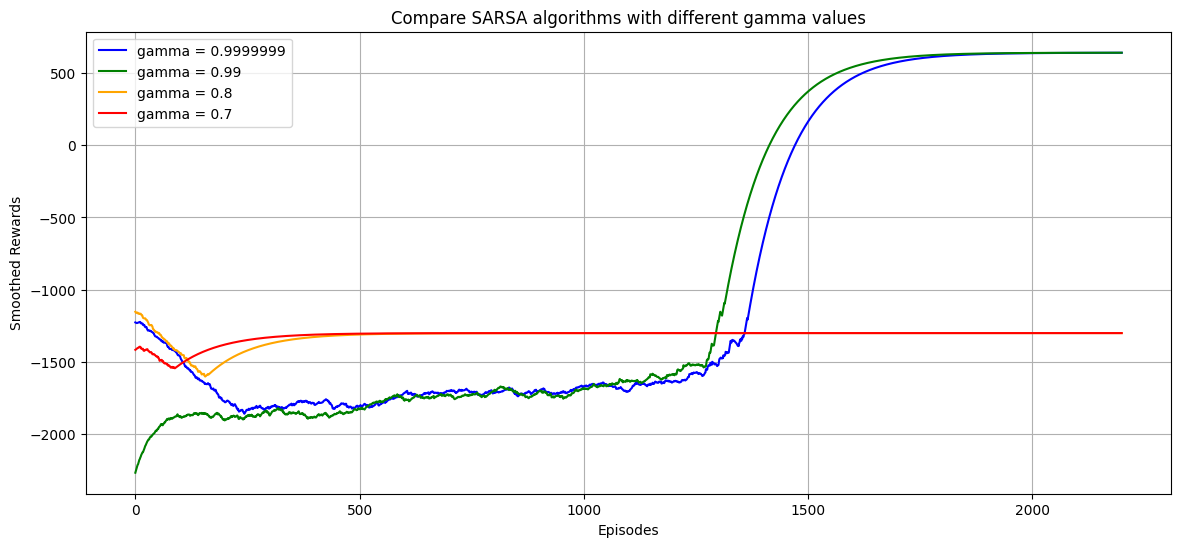

In [69]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  gamma1=0.9999999
  gamma2=0.99
  gamma3=0.8
  gamma4=0.7
  agent1 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.9999999999999994, gamma=gamma1)
  rewardsSARSA1 = agent1.learn("SARSA")
  agent2 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.9999999999999994, gamma=gamma2)
  rewardsSARSA2 = agent2.learn("SARSA")
  agent3 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.9999999999999994, gamma=gamma3)
  rewardsSARSA3 = agent3.learn("SARSA")
  agent4 = RLAgent(env, num_episodes=2200,epsilon=0, alpha=0.9999999999999994, gamma=gamma4)
  rewardsSARSA4 = agent4.learn("SARSA")
  print(f"The maximum returns for\ngamma = {gamma1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\ngamma = {gamma2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\ngamma = {gamma3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\ngamma = {gamma4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'gamma = {gamma1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'gamma = {gamma2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'gamma = {gamma3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'gamma = {gamma4}', color='red')

  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare SARSA algorithms with different gamma values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Taking the analysis of gamma values further, we now test the range of gamma near 0.99.


As seen from the graph below, we see that alpha the graoph with alpha=0.9923 it achieved the maximum return with a smaller episode even though it's smoothed return is did not increase the fastest.

The maximum returns for
gamma = 0.9923: 642   episode: 1281
gamma = 0.9921: 642   episode: 1247
gamma = 0.992: 642   episode: 1248
gamma = 0.9909: 642   episode: 1288
gamma = 0.9907: 642   episode: 1307


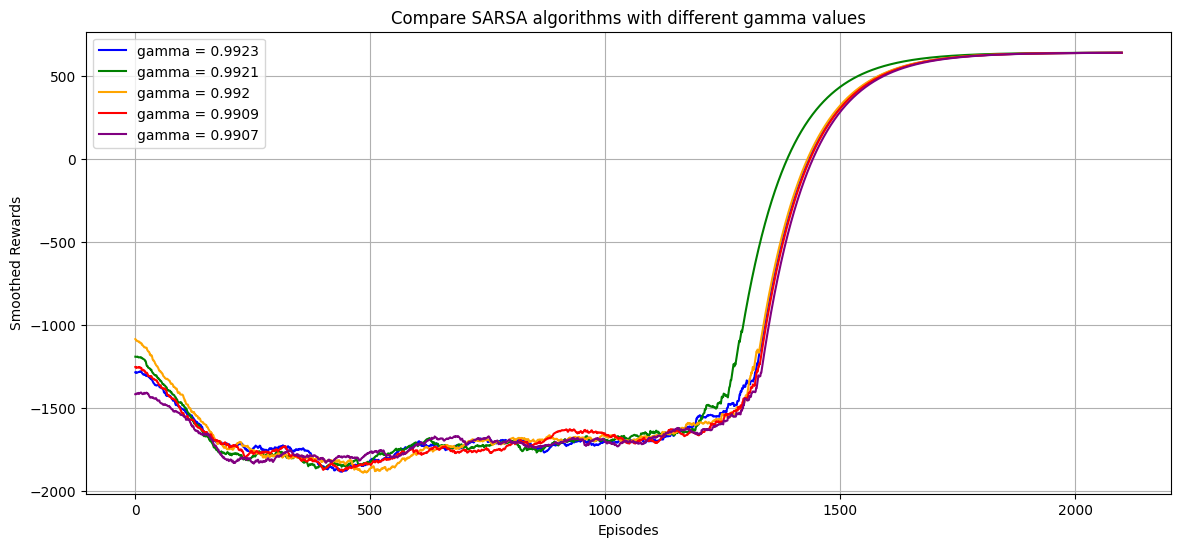

In [70]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  gamma1=0.9923
  gamma2=0.9921
  gamma3=0.992
  gamma4=0.9909
  gamma5=0.9907

  agent1 = RLAgent(env, num_episodes=2100,epsilon=0, alpha=0.9999999999999994, gamma=gamma1)
  rewardsSARSA1 = agent1.learn("SARSA")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=0, alpha=0.9999999999999994, gamma=gamma2)
  rewardsSARSA2 = agent2.learn("SARSA")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=0, alpha=0.9999999999999994, gamma=gamma3)
  rewardsSARSA3 = agent3.learn("SARSA")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=0, alpha=0.9999999999999994, gamma=gamma4)
  rewardsSARSA4 = agent4.learn("SARSA")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=0, alpha=0.9999999999999994, gamma=gamma5)
  rewardsSARSA5 = agent5.learn("SARSA")
  print(f"The maximum returns for\ngamma = {gamma1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\ngamma = {gamma2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\ngamma = {gamma3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\ngamma = {gamma4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\ngamma = {gamma5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'gamma = {gamma1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'gamma = {gamma2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'gamma = {gamma3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'gamma = {gamma4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'gamma = {gamma5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare SARSA algorithms with different gamma values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Enhancing the epsilon. We can see that epsilon=0 is the best.

The maximum returns for
epsilon = 0.2: -1039   episode: 7
epsilon = 0.1: -1039   episode: 388
epsilon = 0.001: 642   episode: 1265
epsilon = 0.0001: -882   episode: 700
epsilon = 0: 642   episode: 1325


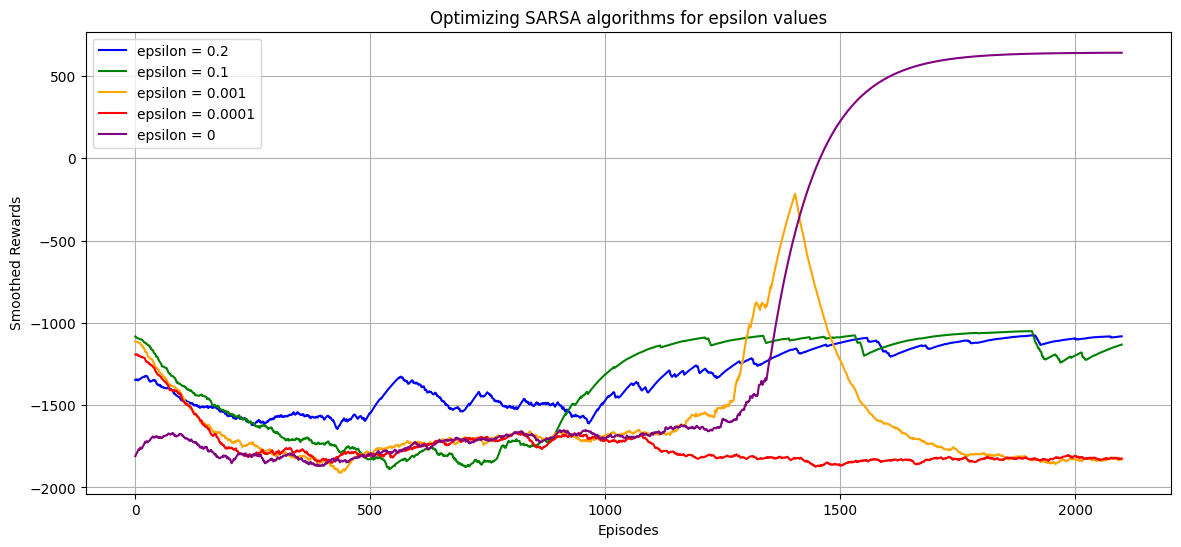

In [71]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  epsilon1=0.2
  epsilon2=0.1
  epsilon3=0.001
  epsilon4=0.0001
  epsilon5=0

  agent1 = RLAgent(env, num_episodes=2100,epsilon=epsilon1, alpha=0.9999999999999994, gamma=0.9923)
  rewardsSARSA1 = agent1.learn("SARSA")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=epsilon2, alpha=0.9999999999999994, gamma=0.9923)
  rewardsSARSA2 = agent2.learn("SARSA")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=epsilon3, alpha=0.9999999999999994, gamma=0.9923)
  rewardsSARSA3 = agent3.learn("SARSA")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=epsilon4, alpha=0.9999999999999994, gamma=0.9923)
  rewardsSARSA4 = agent4.learn("SARSA")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=epsilon5, alpha=0.9999999999999994, gamma=0.9923)
  rewardsSARSA5 = agent5.learn("SARSA")
  print(f"The maximum returns for\nepsilon = {epsilon1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nepsilon = {epsilon2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nepsilon = {epsilon3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nepsilon = {epsilon4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nepsilon = {epsilon5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'epsilon = {epsilon1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'epsilon = {epsilon2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'epsilon = {epsilon3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'epsilon = {epsilon4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'epsilon = {epsilon5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Optimizing SARSA algorithms for epsilon values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

========================================================================================================
Q-Learning optimization, epsilon
=========================================================================================================================================================

The maximum returns for
epsilon = 0.2: -921   episode: 1926
epsilon = 0.1: -851   episode: 1540
epsilon = 0.001: 642   episode: 1847
epsilon = 0.0001: 642   episode: 1729
epsilon = 0: 642   episode: 1776


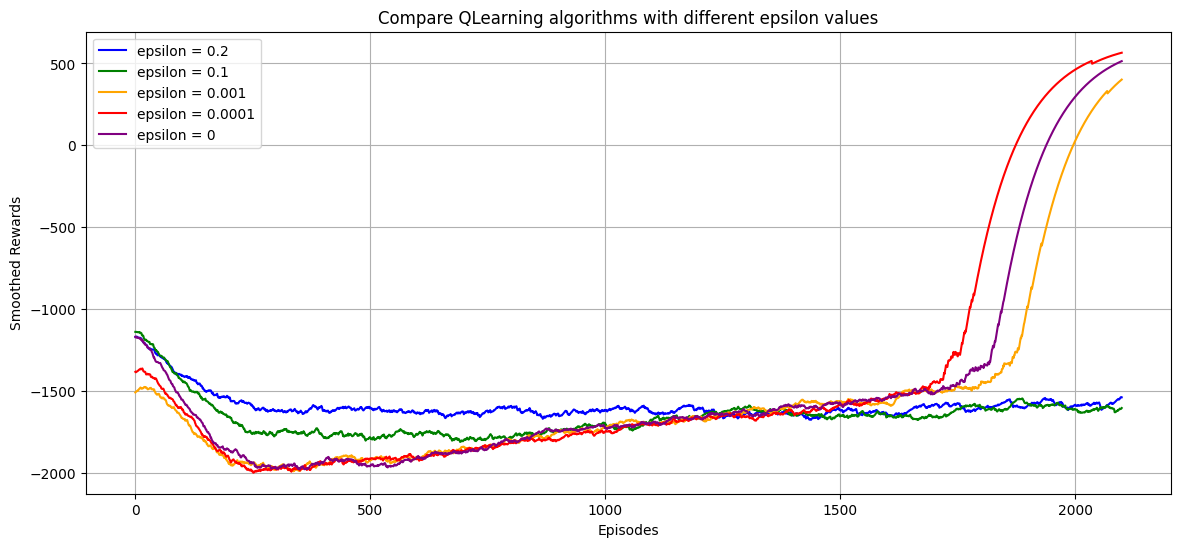

In [72]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  epsilon1=0.2
  epsilon2=0.1
  epsilon3=0.001
  epsilon4=0.0001
  epsilon5=0

  agent1 = RLAgent(env, num_episodes=2100,epsilon=epsilon1, alpha=0.5, gamma=0.99)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=epsilon2, alpha=0.5, gamma=0.99)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=epsilon3, alpha=0.5, gamma=0.99)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=epsilon4, alpha=0.5, gamma=0.99)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=epsilon5, alpha=0.5, gamma=0.99)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\nepsilon = {epsilon1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nepsilon = {epsilon2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nepsilon = {epsilon3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nepsilon = {epsilon4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nepsilon = {epsilon5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'epsilon = {epsilon1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'epsilon = {epsilon2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'epsilon = {epsilon3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'epsilon = {epsilon4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'epsilon = {epsilon5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare QLearning algorithms with different epsilon values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Further enhance epsilon at 0.0001. 0.00008 is the best

The maximum returns for
epsilon = 0.2: -873   episode: 2029
epsilon = 0.1: 149   episode: 1641
epsilon = 0.0001: 642   episode: 1795
epsilon = 9e-05: 642   episode: 1841
epsilon = 8e-05: 642   episode: 1752


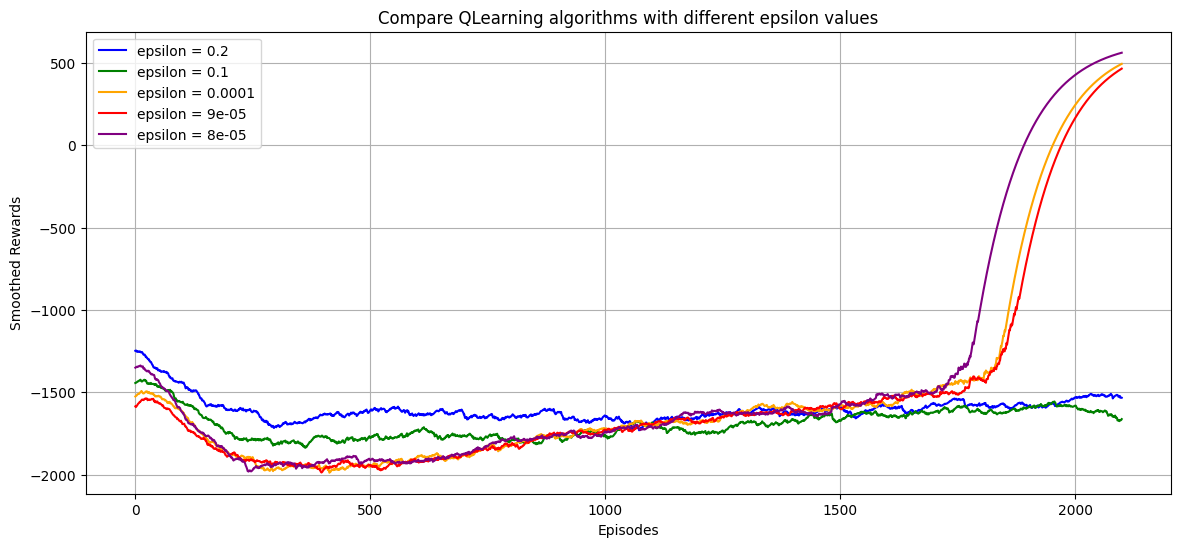

In [73]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  epsilon1=0.2
  epsilon2=0.1
  epsilon3=0.0001
  epsilon4=0.00009
  epsilon5=0.00008

  agent1 = RLAgent(env, num_episodes=2100,epsilon=epsilon1, alpha=0.5, gamma=0.99)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=epsilon2, alpha=0.5, gamma=0.99)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=epsilon3, alpha=0.5, gamma=0.99)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=epsilon4, alpha=0.5, gamma=0.99)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=epsilon5, alpha=0.5, gamma=0.99)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\nepsilon = {epsilon1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nepsilon = {epsilon2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nepsilon = {epsilon3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nepsilon = {epsilon4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nepsilon = {epsilon5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'epsilon = {epsilon1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'epsilon = {epsilon2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'epsilon = {epsilon3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'epsilon = {epsilon4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'epsilon = {epsilon5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare QLearning algorithms with different epsilon values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Optimize alpha in Q Learning

The maximum returns for
alpha = 0.52: 642   episode: 1777
alpha = 0.51: 642   episode: 1770
alpha = 0.5: 642   episode: 1748
alpha = 0.49: 642   episode: 1839
alpha = 0.48: 642   episode: 1836


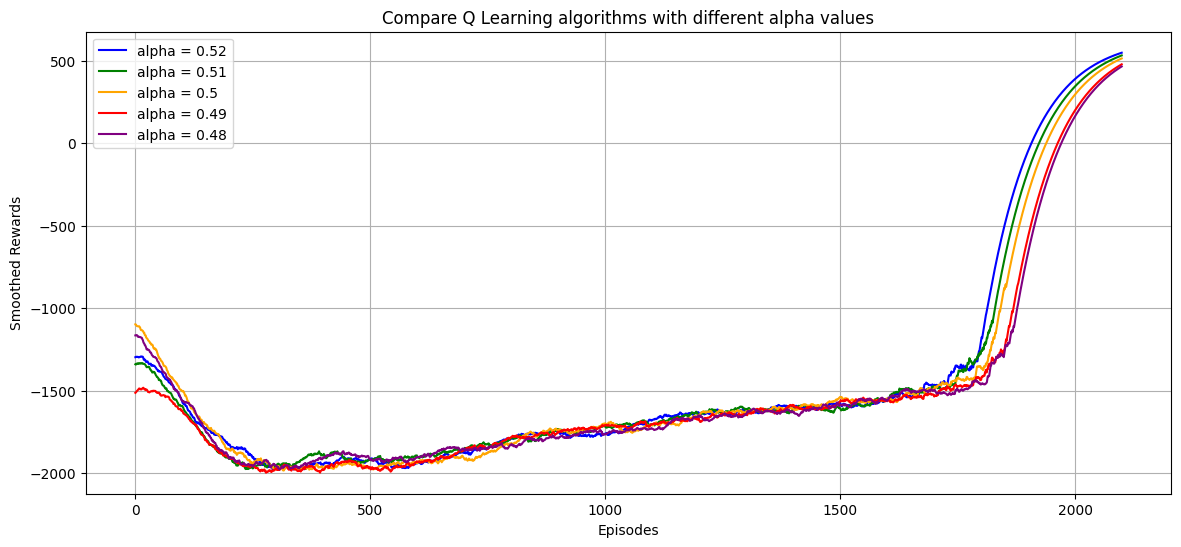

In [74]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  alpha1=0.52
  alpha2=0.51
  alpha3=0.5
  alpha4=0.49
  alpha5=0.48

  agent1 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha1, gamma=0.99)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha2, gamma=0.99)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha3, gamma=0.99)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha4, gamma=0.99)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha5, gamma=0.99)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\nalpha = {alpha1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nalpha = {alpha2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nalpha = {alpha3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nalpha = {alpha4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nalpha = {alpha5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'alpha = {alpha1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'alpha = {alpha2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'alpha = {alpha3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'alpha = {alpha4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'alpha = {alpha5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare Q Learning algorithms with different alpha values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

The maximum returns for
alpha = 0.502: 642   episode: 1754
alpha = 0.501: 642   episode: 1821
alpha = 0.5: 642   episode: 1746
alpha = 0.499: 642   episode: 1733
alpha = 0.498: 642   episode: 1698


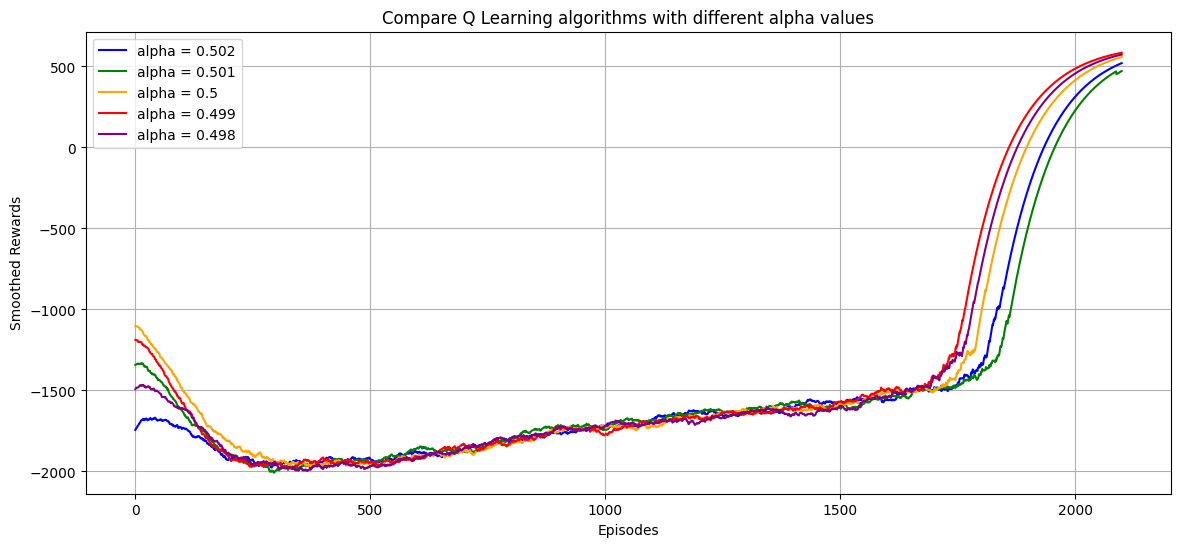

In [75]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  alpha1=0.502
  alpha2=0.501
  alpha3=0.5
  alpha4=0.499
  alpha5=0.498

  agent1 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha1, gamma=0.99)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha2, gamma=0.99)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha3, gamma=0.99)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha4, gamma=0.99)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=alpha5, gamma=0.99)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\nalpha = {alpha1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nalpha = {alpha2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\nalpha = {alpha3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\nalpha = {alpha4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\nalpha = {alpha5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'alpha = {alpha1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'alpha = {alpha2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'alpha = {alpha3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'alpha = {alpha4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'alpha = {alpha5}', color='purple')


  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare Q Learning algorithms with different alpha values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Q-Learning, optimize gamma.

The maximum returns for
gamma = 0.992: 642   episode: 1825
gamma = 0.991: 642   episode: 1776
gamma = 0.99: 642   episode: 1801
gamma = 0.989: 642   episode: 1804
gamma = 0.988: 642   episode: 1788


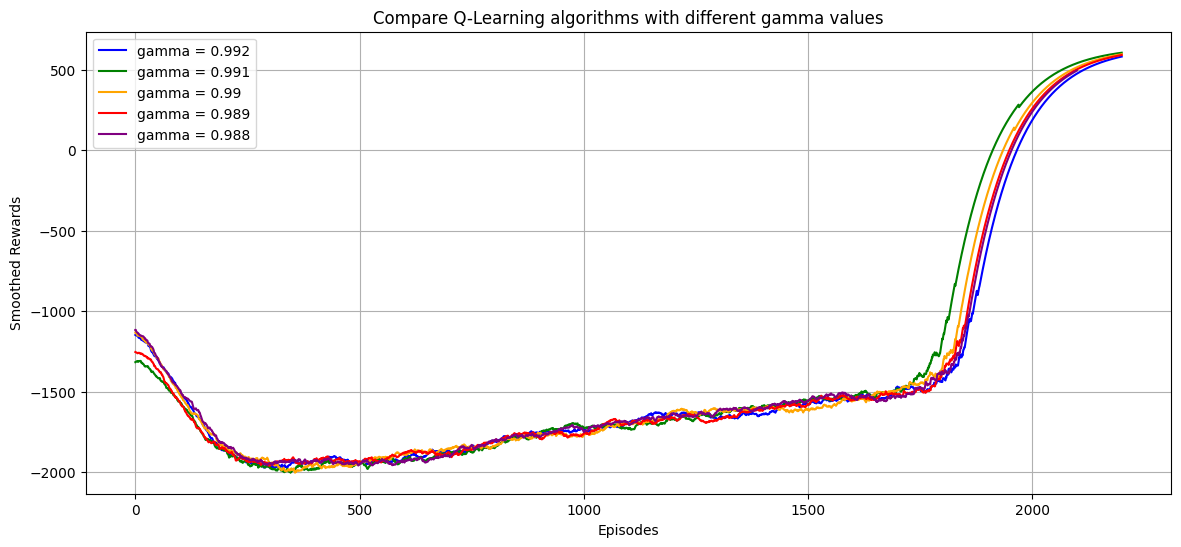

In [76]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  gamma1=0.992
  gamma2=0.991
  gamma3=0.99
  gamma4=0.989
  gamma5=0.988
  agent1 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma1)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma2)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma3)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma4)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=0.5, gamma=gamma5)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\ngamma = {gamma1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\ngamma = {gamma2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\ngamma = {gamma3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\ngamma = {gamma4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\ngamma = {gamma5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'gamma = {gamma1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'gamma = {gamma2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'gamma = {gamma3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'gamma = {gamma4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'gamma = {gamma5}', color='purple')

  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare Q-Learning algorithms with different gamma values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

The maximum returns for
gamma = 0.9899: 642   episode: 1809
gamma = 0.9899: 642   episode: 1805
gamma = 0.989: 642   episode: 1775
gamma = 0.988: 642   episode: 1761
gamma = 0.987: 642   episode: 1793


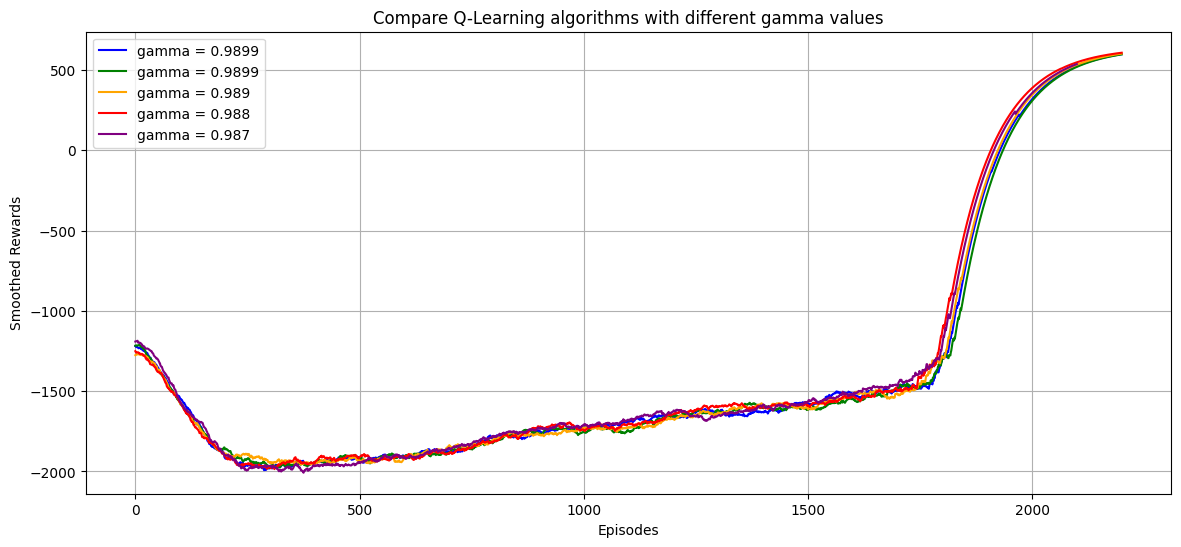

In [77]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
  env = CliffBoxGridWorld()
  gamma1=0.9899
  gamma2=0.9899
  gamma3=0.989
  gamma4=0.988
  gamma5=0.987
  agent1 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma1)
  rewardsSARSA1 = agent1.learn("QLearning")
  agent2 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma2)
  rewardsSARSA2 = agent2.learn("QLearning")
  agent3 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma3)
  rewardsSARSA3 = agent3.learn("QLearning")
  agent4 = RLAgent(env, num_episodes=2200,epsilon=0.00008, alpha=0.5, gamma=gamma4)
  rewardsSARSA4 = agent4.learn("QLearning")
  agent5 = RLAgent(env, num_episodes=2100,epsilon=0.00008, alpha=0.5, gamma=gamma5)
  rewardsSARSA5 = agent5.learn("QLearning")
  print(f"The maximum returns for\ngamma = {gamma1}: {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\ngamma = {gamma2}: {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}\ngamma = {gamma3}: {max(rewardsSARSA3)}   episode: {rewardsSARSA3.index(max(rewardsSARSA3))}\ngamma = {gamma4}: {max(rewardsSARSA4)}   episode: {rewardsSARSA4.index(max(rewardsSARSA4))}\ngamma = {gamma5}: {max(rewardsSARSA5)}   episode: {rewardsSARSA5.index(max(rewardsSARSA5))}")

  # Create a larger figure
  plt.figure(figsize=(14, 6))
  weight = 0.99

  # Plot SARSA
  plt.plot(plotgraph(weight,rewardsSARSA1), label=f'gamma = {gamma1}', color='blue')
  plt.plot(plotgraph(weight,rewardsSARSA2), label=f'gamma = {gamma2}', color='green')
  plt.plot(plotgraph(weight,rewardsSARSA3), label=f'gamma = {gamma3}', color='orange')
  plt.plot(plotgraph(weight,rewardsSARSA4), label=f'gamma = {gamma4}', color='red')
  plt.plot(plotgraph(weight,rewardsSARSA5), label=f'gamma = {gamma5}', color='purple')

  # Add labels and legend
  plt.xlabel('Episodes')
  plt.ylabel('Smoothed Rewards')
  plt.title('Compare Q-Learning algorithms with different gamma values')
  plt.legend()

  # Add grids
  plt.grid(True)

  plt.legend()

  # Show the plot
  plt.show()

main()

Optimum SARSA and Q-Learning graph from guess and check
==================================================================================

The maximum returns for
Q-Learning: 642   episode: 1778
SARSA: 642   episode: 1292


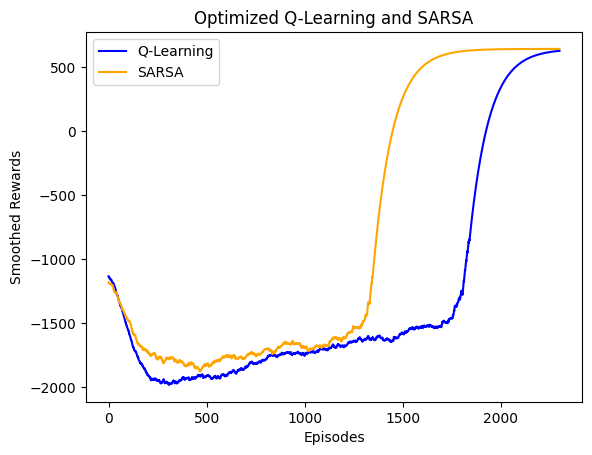

In [78]:
env = CliffBoxGridWorld()
agentRL = RLAgent(env, num_episodes=2300,epsilon=0.00008, alpha=0.5, gamma=0.987)
rewardsQL = agentRL.learn("QLearning")
agentSARSA = RLAgent(env, num_episodes=2300,epsilon=0, alpha=0.9999999999999994, gamma=0.9923)
rewardsSARSA = agentSARSA.learn("SARSA")
print(f"The maximum returns for\nQ-Learning: {max(rewardsQL)}   episode: {rewardsQL.index(max(rewardsQL))}\nSARSA: {max(rewardsSARSA)}   episode: {rewardsSARSA.index(max(rewardsSARSA))}")

# Smooth plot Q-Learning
weight = 0.99
lastQL = rewardsQL[0]
smoothedQL = []
for v in rewardsQL:
    smoothed_val = lastQL * weight + (1 - weight) * v
    smoothedQL.append(smoothed_val)
    lastQL = smoothed_val

# Plot the learning curve for Q-Learning
plt.plot(smoothedQL, label='Q-Learning', color='blue')

# Smooth plot SARSA
lastSARSA = rewardsSARSA[0]
smoothedSARSA = []
for v in rewardsSARSA:
    smoothed_val = lastSARSA * weight + (1 - weight) * v
    smoothedSARSA.append(smoothed_val)
    lastSARSA = smoothed_val

# Plot the learning curve for SARSA
plt.plot(smoothedSARSA, label='SARSA', color='orange')

# Add labels and legend
plt.xlabel('Episodes')
plt.ylabel('Smoothed Rewards')
plt.title('Optimized Q-Learning and SARSA')
plt.legend()

# Show the plot
plt.show()


Bayesian Optimized SARSA and Q-Learning graph from guess and check
==================================================================================

The maximum returns for
Q-Learning: 642   episode: 1806
SARSA: 642   episode: 1275


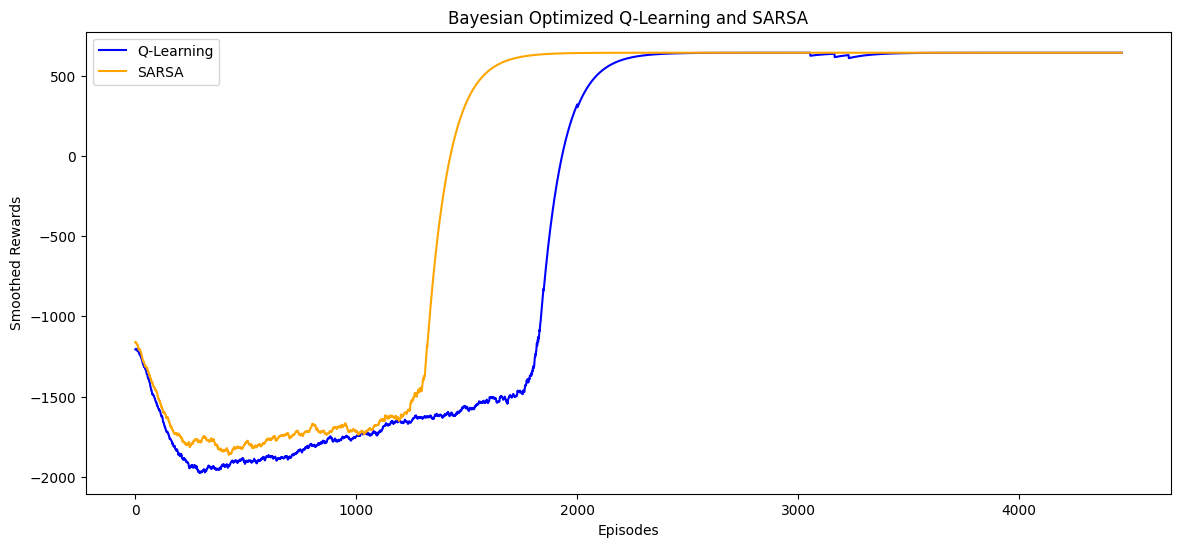

In [79]:
env = CliffBoxGridWorld()
agentRL = RLAgent(env, num_episodes=4465,epsilon=0.00009507143064099161, alpha=0.4949816047538945, gamma=0.987319939418114)
rewardsQL = agentRL.learn("QLearning")
agentSARSA = RLAgent(env, num_episodes=4465,epsilon=0.0000015599452033620266, alpha=0.9915601848442379, gamma=0.9902323344486728)
rewardsSARSA = agentSARSA.learn("SARSA")
print(f"The maximum returns for\nQ-Learning: {max(rewardsQL)}   episode: {rewardsQL.index(max(rewardsQL))}\nSARSA: {max(rewardsSARSA)}   episode: {rewardsSARSA.index(max(rewardsSARSA))}")

plt.figure(figsize=(14, 6))
# Smooth plot Q-Learning
weight = 0.99
lastQL = rewardsQL[0]
smoothedQL = []
for v in rewardsQL:
    smoothed_val = lastQL * weight + (1 - weight) * v
    smoothedQL.append(smoothed_val)
    lastQL = smoothed_val

# Plot the learning curve for Q-Learning
plt.plot(smoothedQL, label='Q-Learning', color='blue')

# Smooth plot SARSA
lastSARSA = rewardsSARSA[0]
smoothedSARSA = []
for v in rewardsSARSA:
    smoothed_val = lastSARSA * weight + (1 - weight) * v
    smoothedSARSA.append(smoothed_val)
    lastSARSA = smoothed_val

# Plot the learning curve for SARSA
plt.plot(smoothedSARSA, label='SARSA', color='orange')

# Add labels and legend
plt.xlabel('Episodes')
plt.ylabel('Smoothed Rewards')
plt.title('Bayesian Optimized Q-Learning and SARSA')
plt.legend()

# Show the plot
plt.show()


**Bonus Component**
==

Compare different exploration techniques (such as UCB) with the default epsilon-greedy and non-exploration strategy.
=================================

SARSA-QLearning greedy: epsilon=0 and epsilon=0.001, with exploration

The maximum returns for
Q-Learning (epsilon = 0): 642   episode: 1714
Q-Learning (epsilon = 0.001): 642   episode: 1833
SARSA (epsilon = 0): 642   episode: 1235
SARSA (epsilon = 0.001): 642   episode: 1258


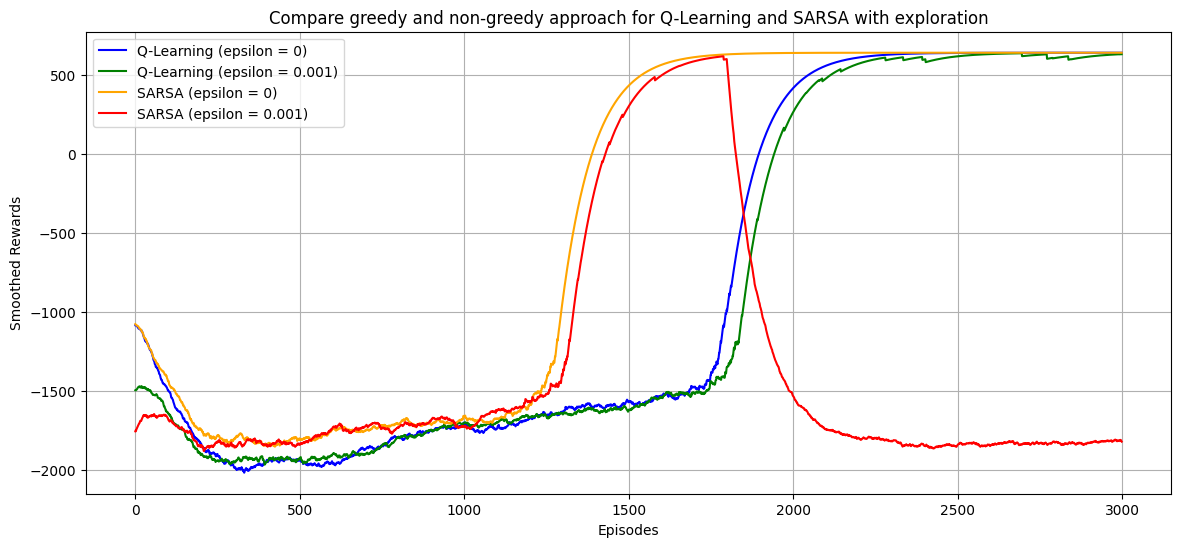

In [80]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
    env = CliffBoxGridWorld()
    agentRL1 = RLAgent(env, num_episodes=3000,epsilon=0, alpha=0.4949816047538945, gamma=0.987319939418114)
    rewardsQL1 = agentRL1.learn("QLearning")
    agentRL2 = RLAgent(env, num_episodes=3000,epsilon=0.001, alpha=0.4949816047538945, gamma=0.987319939418114)
    rewardsQL2 = agentRL2.learn("QLearning")
    agentSARSA1 = RLAgent(env, num_episodes=3000,epsilon=0, alpha=0.9915601848442379, gamma=0.9902323344486728)
    rewardsSARSA1 = agentSARSA1.learn("SARSA")
    agentSARSA2 = RLAgent(env, num_episodes=3000,epsilon=0.001, alpha=0.9915601848442379, gamma=0.9902323344486728)
    rewardsSARSA2 = agentSARSA2.learn("SARSA")
    print(f"The maximum returns for\nQ-Learning (epsilon = 0): {max(rewardsQL1)}   episode: {rewardsQL1.index(max(rewardsQL1))}\nQ-Learning (epsilon = 0.001): {max(rewardsQL2)}   episode: {rewardsQL2.index(max(rewardsQL2))}\nSARSA (epsilon = 0): {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nSARSA (epsilon = 0.001): {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}")

    # Create a larger figure
    plt.figure(figsize=(14, 6))
    weight = 0.99

    # Plot SARSA
    plt.plot(plotgraph(weight,rewardsQL1), label=f'Q-Learning (epsilon = 0)', color='blue')
    plt.plot(plotgraph(weight,rewardsQL2), label=f'Q-Learning (epsilon = 0.001)', color='green')
    plt.plot(plotgraph(weight,rewardsSARSA1), label=f'SARSA (epsilon = 0)', color='orange')
    plt.plot(plotgraph(weight,rewardsSARSA2), label=f'SARSA (epsilon = 0.001)', color='red')

    # Add labels and legend
    plt.xlabel('Episodes')
    plt.ylabel('Smoothed Rewards')
    plt.title('Compare greedy and non-greedy approach for Q-Learning and SARSA with exploration')
    plt.legend()

    # Add grids
    plt.grid(True)

    plt.legend()

    # Show the plot
    plt.show()

main()

SARSA-QLearning greedy: epsilon=0 and epsilon=0.001, **without** exploration

The maximum returns for
Q-Learning (epsilon = 0): 642   episode: 1799
Q-Learning (epsilon = 0.001): 642   episode: 1763
SARSA (epsilon = 0): 642   episode: 1265
SARSA (epsilon = 0.001): 642   episode: 1247


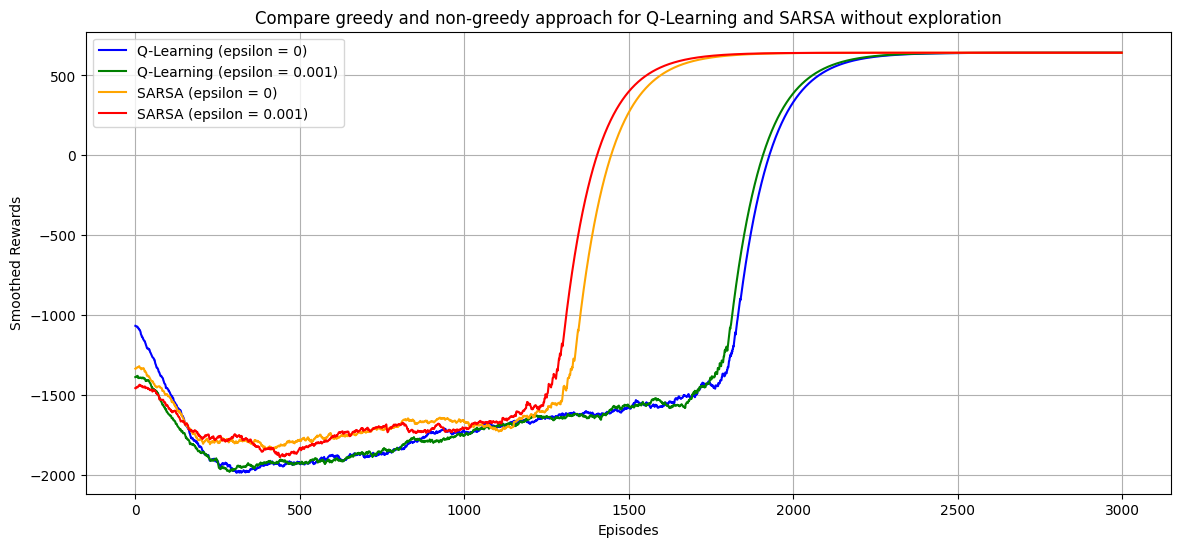

In [10]:
# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
    env = CliffBoxGridWorld()
    agentRL1 = RLAgent(env, num_episodes=3000,epsilon=0, alpha=0.4949816047538945, gamma=0.987319939418114)
    rewardsQL1 = agentRL1.learn_noExploration("QLearning")
    agentRL2 = RLAgent(env, num_episodes=3000,epsilon=0.001, alpha=0.4949816047538945, gamma=0.987319939418114)
    rewardsQL2 = agentRL2.learn_noExploration("QLearning")
    agentSARSA1 = RLAgent(env, num_episodes=3000,epsilon=0, alpha=0.9915601848442379, gamma=0.9902323344486728)
    rewardsSARSA1 = agentSARSA1.learn_noExploration("SARSA")
    agentSARSA2 = RLAgent(env, num_episodes=3000,epsilon=0.001, alpha=0.9915601848442379, gamma=0.9902323344486728)
    rewardsSARSA2 = agentSARSA2.learn_noExploration("SARSA")
    print(f"The maximum returns for\nQ-Learning (epsilon = 0): {max(rewardsQL1)}   episode: {rewardsQL1.index(max(rewardsQL1))}\nQ-Learning (epsilon = 0.001): {max(rewardsQL2)}   episode: {rewardsQL2.index(max(rewardsQL2))}\nSARSA (epsilon = 0): {max(rewardsSARSA1)}   episode: {rewardsSARSA1.index(max(rewardsSARSA1))}\nSARSA (epsilon = 0.001): {max(rewardsSARSA2)}   episode: {rewardsSARSA2.index(max(rewardsSARSA2))}")

    # Create a larger figure
    plt.figure(figsize=(14, 6))
    weight = 0.99

    # Plot SARSA
    plt.plot(plotgraph(weight,rewardsQL1), label=f'Q-Learning (epsilon = 0)', color='blue')
    plt.plot(plotgraph(weight,rewardsQL2), label=f'Q-Learning (epsilon = 0.001)', color='green')
    plt.plot(plotgraph(weight,rewardsSARSA1), label=f'SARSA (epsilon = 0)', color='orange')
    plt.plot(plotgraph(weight,rewardsSARSA2), label=f'SARSA (epsilon = 0.001)', color='red')

    # Add labels and legend
    plt.xlabel('Episodes')
    plt.ylabel('Smoothed Rewards')
    plt.title('Compare greedy and non-greedy approach for Q-Learning and SARSA without exploration')
    plt.legend()

    # Add grids
    plt.grid(True)

    plt.legend()

    # Show the plot
    plt.show()

main()

V-Table for SARSA
==

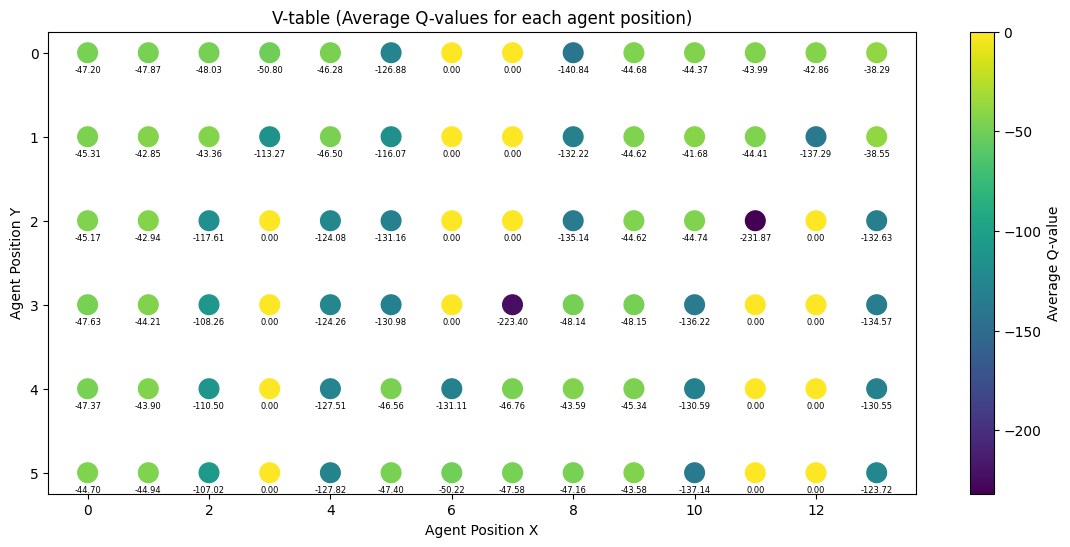

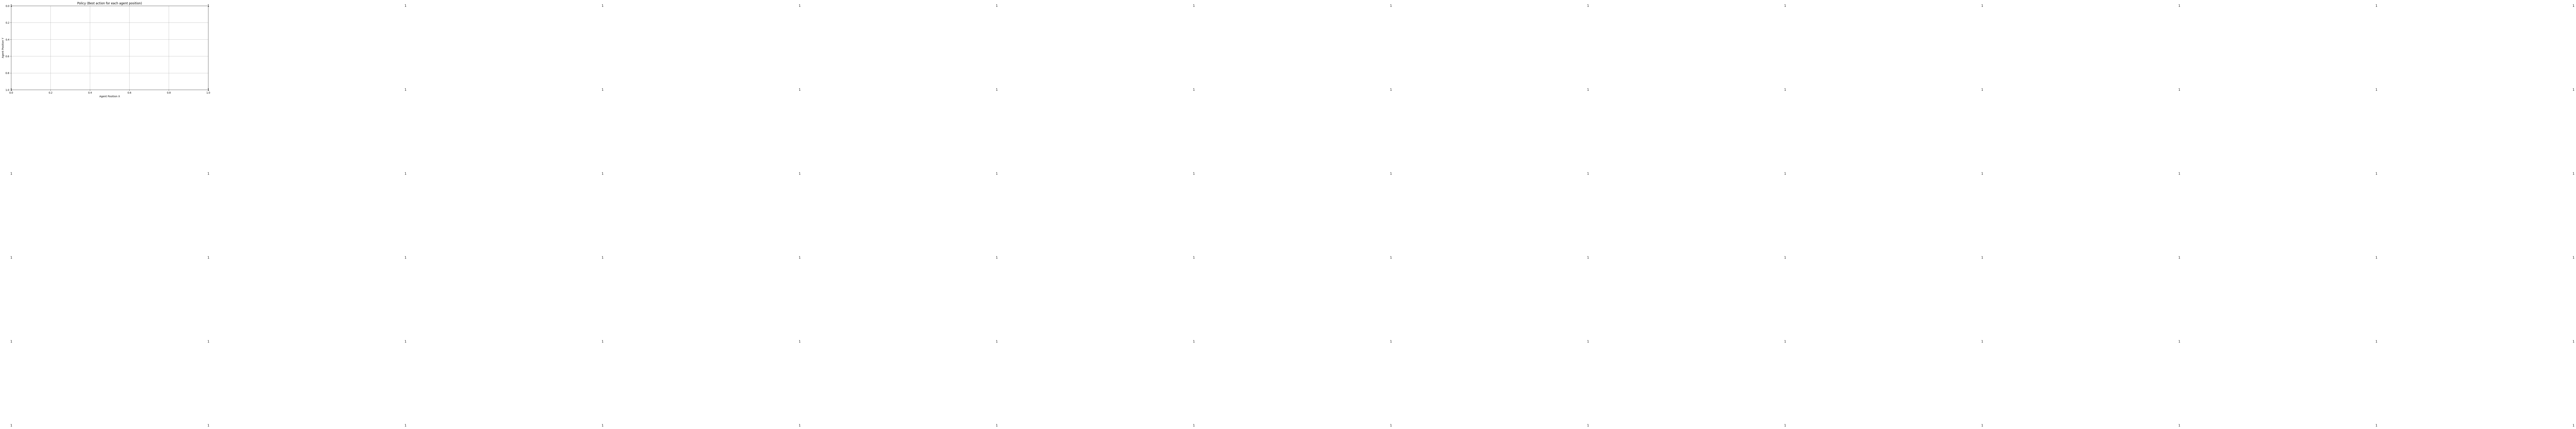

In [26]:
def visualize(q_table):
    v_table = {}
    policy = {}
    actions = {1: 'Up', 2: 'Down', 3: 'Left', 4: 'Right'}

    # Loop over all entries in the Q-table
    for key, value in q_table.items():
        agent_position = (key[1], key[0])

        if agent_position not in v_table:
            v_table[agent_position] = []
        v_table[agent_position].append(np.mean(list(value.values())))

        if agent_position not in policy:
            policy[agent_position] = []
        try:
            best_action = np.argmax([value[i] for i in range(1, 5)]) + 1
            policy[agent_position].append(best_action)
        except KeyError as e:
            print(f"KeyError encountered for agent position: {agent_position}, value: {value}, missing key: {e}")

    # Extract average Q-values and corresponding positions
    positions = list(v_table.keys())
    average_q_values = [np.mean(v) for v in v_table.values()]
    return [positions,average_q_values,v_table,policy]

def plot(positions, average_q_values, v_table,policy):
    # Visualize the V-table with adjusted colorbar scale
    plt.figure(figsize=(14, 6))
    x, y = zip(*positions)

    # Calculate min and max Q-values
    q_min = np.min(average_q_values)
    q_max = np.max(average_q_values)

    scatter = plt.scatter(x, y, c=average_q_values, s=200, cmap='viridis', vmin=q_min, vmax=q_max)
    plt.colorbar(scatter, label='Average Q-value')

    # Annotate each point with its Q-value and add a vertical offset
    offset = 0.2  # Adjust the offset as needed
    for (xi, yi, qi) in zip(x, y, average_q_values):
        plt.text(xi, yi + offset, f'{qi:.2f}', ha='center', va='center', fontsize=6, color='black')

    plt.title('V-table (Average Q-values for each agent position)')
    plt.xlabel('Agent Position X')
    plt.ylabel('Agent Position Y')
    plt.gca().invert_yaxis()
    plt.show()

    # Visualize the Policy
    plt.figure(figsize=(14, 6))
    for k, v in policy.items():
        plt.text(k[0], k[1], str(v[0]), ha='center', va='center', fontsize=12, color='black')
    plt.title('Policy (Best action for each agent position)')
    plt.xlabel('Agent Position X')
    plt.ylabel('Agent Position Y')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()




def main():
  agentSARSA = RLAgent(env, num_episodes=2000, epsilon=0.0000015599452033620266, alpha=0.9915601848442379, gamma=0.9902323344486728)
  rewardsSARSA = agentSARSA.learn("SARSA")
  objectReturn=visualize(agentSARSA.q_table)
  plot(objectReturn[0],objectReturn[1],objectReturn[2],objectReturn[3])

main()

Step-by-step approach visualization of the learnt-policy: Optimum SARSA
====================

In [83]:
def main_policyVisualization():
  env = CliffBoxGridWorld(render=True)
  # Reset the environment and print the initial state
  state = env.reset()
  env.print_world()

  #Train RLAgent
  #agent = RLAgent(env, num_episodes=2200,epsilon=0.01, alpha=0.5, gamma=0.99)
  agent = RLAgent(env, num_episodes=2000, epsilon=0.0000015599452033620266, alpha=0.9915601848442379, gamma=0.9902323344486728)
  rewards = agent.learn("SARSA")

  # Build a policy from the q_table
  policy = build_policy(agent.q_table)

  # Reset the environment and print the initial state
  state = env.reset()

  done = False
  total_reward = 0

  while not done:
      # Use the policy to select the action that maximizes the Q-value
      action = policy[state]
      state, reward, done, info = env.step(action)

      total_reward += reward

      # Print the current step information
      print(f'step: {env.timesteps}, state: {state}, action: {action}, reward: {reward}')

      # Print the updated world grid
      env.print_world()

  print(f'Total reward: {total_reward}')
  print(f'Action history: {env.action_history}')

# Creating policy by selecting the action which gives the maximum accumulated value for each state
def build_policy(q_table):
    policy = {}
    for state, action_values in q_table.items():
        best_action = max(action_values, key=action_values.get)
        policy[state] = best_action
    return policy

main_policyVisualization()

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), action: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'B' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'A' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']]
step: 2, state: (4, 1, 3, 1), action: 1, reward: -15
Action

Policy Visualisation: Optimum Q-Learning
===
We can see that both Q-Learning and SARSA gives the maximym reward with the same number of moves

In [ ]:
def main_policyVisualization():
  env = CliffBoxGridWorld(render=True)
  # Reset the environment and print the initial state
  state = env.reset()
  env.print_world()

  #Train RLAgent
  #agent = RLAgent(env, num_episodes=2200,epsilon=0.01, alpha=0.5, gamma=0.99)
  agent = RLAgent(env, num_episodes=2300,epsilon=0.00008, alpha=0.5, gamma=0.987)
  rewards = agent.learn("SARSA")

  # Build a policy from the q_table
  policy = build_policy(agent.q_table)

  # Reset the environment and print the initial state
  state = env.reset()

  done = False
  total_reward = 0

  while not done:
      # Use the policy to select the action that maximizes the Q-value
      action = policy[state]
      state, reward, done, info = env.step(action)

      total_reward += reward

      # Print the current step information
      print(f'step: {env.timesteps}, state: {state}, action: {action}, reward: {reward}')

      # Print the updated world grid
      env.print_world()

  print(f'Total reward: {total_reward}')
  print(f'Action history: {env.action_history}')

# Creating policy by selecting the action which gives the maximum accumulated value for each state
def build_policy(q_table):
    policy = {}
    for state, action_values in q_table.items():
        best_action = max(action_values, key=action_values.get)
        policy[state] = best_action
    return policy

main_policyVisualization()

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), action: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'B' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'A' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'_']]
step: 2, state: (4, 1, 3, 1), action: 1, reward: -15
Action

Sparse reward
=============

The maximum returns for
Q-Learning: 0   episode: 15
SARSA: 0   episode: 13


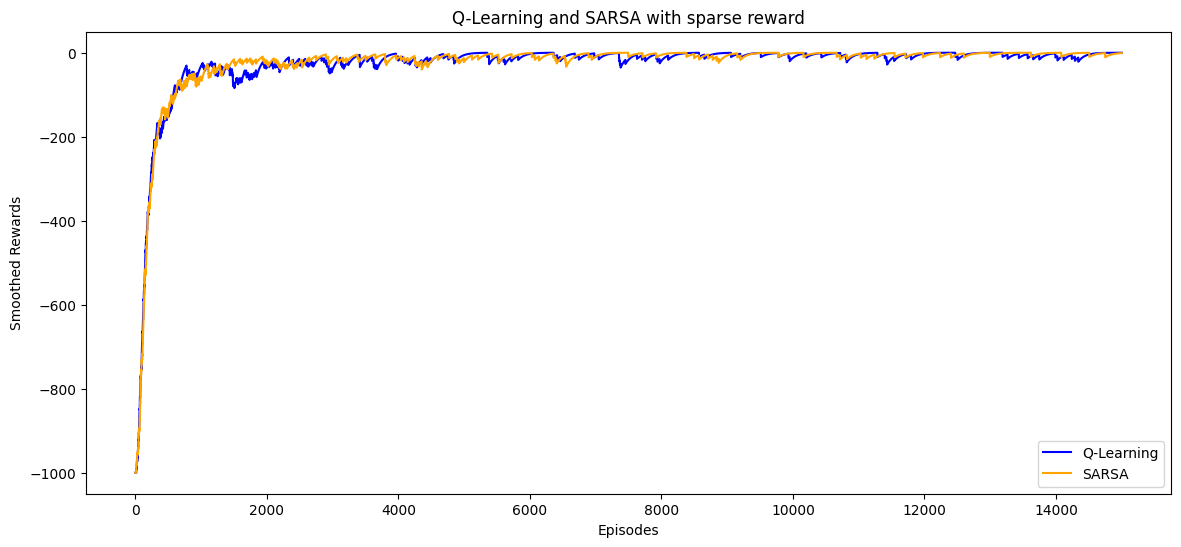

In [8]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
    env = CliffBoxGridWorld()
    agentRL = RLAgent(env, num_episodes=15000,epsilon=0.00009507143064099161, alpha=0.4949816047538945, gamma=0.987319939418114)
    rewardsQL = agentRL.learn_sparseReward("QLearning")
    agentSARSA = RLAgent(env, num_episodes=15000,epsilon=0.0000015599452033620266, alpha=0.9915601848442379, gamma=0.9902323344486728)
    rewardsSARSA = agentSARSA.learn_sparseReward("SARSA")
    print(f"The maximum returns for\nQ-Learning: {max(rewardsQL)}   episode: {rewardsQL.index(max(rewardsQL))}\nSARSA: {max(rewardsSARSA)}   episode: {rewardsSARSA.index(max(rewardsSARSA))}")

    plt.figure(figsize=(14, 6))
    # Smooth plot Q-Learning
    weight = 0.99
    lastQL = rewardsQL[0]
    smoothedQL = []
    for v in rewardsQL:
        smoothed_val = lastQL * weight + (1 - weight) * v
        smoothedQL.append(smoothed_val)
        lastQL = smoothed_val

    # Plot the learning curve for Q-Learning
    plt.plot(smoothedQL, label='Q-Learning', color='blue')

    # Smooth plot SARSA
    lastSARSA = rewardsSARSA[0]
    smoothedSARSA = []
    for v in rewardsSARSA:
        smoothed_val = lastSARSA * weight + (1 - weight) * v
        smoothedSARSA.append(smoothed_val)
        lastSARSA = smoothed_val

    # Plot the learning curve for SARSA
    plt.plot(smoothedSARSA, label='SARSA', color='orange')

    # Add labels and legend
    plt.xlabel('Episodes')
    plt.ylabel('Smoothed Rewards')
    plt.title('Q-Learning and SARSA with sparse reward')
    plt.legend()

    # Show the plot
    plt.show()


main()

Bayesian Optimization
==

In [12]:
!pip install scikit-optimize


In [13]:
!pip install bayesian-optimization


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from skopt import BayesSearchCV
from bayes_opt import BayesianOptimization

Optimizing Q-Learning Parameter
==

In [ ]:
env = CliffBoxGridWorld()

class RLEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, env, num_episodes=2100, epsilon=0.01, alpha=0.5, gamma=0.99):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.agent = RLAgent(env, num_episodes=num_episodes, epsilon=epsilon, alpha=alpha, gamma=gamma)

    def fit(self, X=None, y=None):
        self.agent.learn("QLearning")
        return self

    def predict(self, state, action):
        return self.q_table[state][action]

    def score(self, X=None, y=None):
        # Evaluate the agent over multiple runs and return the average reward
        num_runs = 5
        scores = []
        for _ in range(num_runs):
            # Changed to append the last number and not the average number
            rewardList=self.agent.learn("QLearning")
            scores.append(rewardList[-1])
        return np.mean(scores)

def rl_objective(alpha, gamma, epsilon, num_episodes):
    # Define RL environment
    env = CliffBoxGridWorld()

    # Create an instance of RLEstimator
    rl_estimator = RLEstimator(env=env, num_episodes=int(num_episodes), epsilon=epsilon, alpha=alpha, gamma=gamma)

    # Dummy dataset
    X_dummy = np.random.rand(100, 10)
    y_dummy = np.random.choice([0, 1], size=100)

    # Fit the RL agent
    rl_estimator.fit(X_dummy, y_dummy)

    # Return the average score as the objective
    return rl_estimator.score(X_dummy, y_dummy)

# Define the parameter search space
param_space = {
    'alpha': (0.48, 0.52),
    'gamma': (0.98, 0.99),
    'epsilon': (0, 0.0001),
    'num_episodes': (1000, 5000),
}

# Perform Bayesian Optimization
opt = BayesianOptimization(
    f=rl_objective,
    pbounds=param_space,
    random_state=42,
    verbose=2,
)

# Maximize the objective (minimize negative score)
opt.maximize(init_points=5, n_iter=5)

# Get the best hyperparameters
best_hyperparameters = opt.max['params']
print("Best Hyperparameters:", best_hyperparameters)


|   iter    |  target   |   alpha   |  epsilon  |   gamma   | num_ep... |
-------------------------------------------------------------------------
| 1         | 642.0     | 0.495     | 9.507e-05 | 0.9873    | 3.395e+03 |
| 2         | 642.0     | 0.4862    | 1.56e-05  | 0.9806    | 4.465e+03 |
| 3         | 642.0     | 0.504     | 7.081e-05 | 0.9802    | 4.88e+03  |
| 4         | 642.0     | 0.5133    | 2.123e-05 | 0.9818    | 1.734e+03 |
| 5         | 642.0     | 0.4922    | 5.248e-05 | 0.9843    | 2.165e+03 |
| 6         | 642.0     | 0.5113    | 1.468e-06 | 0.9866    | 1e+03     |
| 7         | 642.0     | 0.4967    | 3.101e-05 | 0.9899    | 5e+03     |
| 8         | 642.0     | 0.4891    | 8.865e-05 | 0.984     | 1e+03     |
| 9         | 642.0     | 0.4972    | 8.969e-05 | 0.9851    | 4.999e+03 |
| 10        | 642.0     | 0.5011    | 1.714e-05 | 0.9807    | 1.001e+03 |
Best Hyperparameters: {'alpha': 0.4949816047538945, 'epsilon': 9.507143064099161e-05, 'gamma': 0.987319939418114

Optimizing SARSA parameter
==

In [ ]:
env = CliffBoxGridWorld()

class RLEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, env, num_episodes=2100, epsilon=0.01, alpha=0.5, gamma=0.99):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.agent = RLAgent(env, num_episodes=num_episodes, epsilon=epsilon, alpha=alpha, gamma=gamma)

    def fit(self, X=None, y=None):
        self.agent.learn("SARSA")
        return self

    def predict(self, state, action):
        return self.q_table[state][action]

    def score(self, X=None, y=None):
        # Evaluate the agent over multiple runs and return the average reward
        num_runs = 5
        scores = []
        for _ in range(num_runs):
            # Changed to append the last number and not the average number
            rewardList=self.agent.learn("SARSA")
            scores.append(rewardList[-1])
        return np.mean(scores)

def rl_objective(alpha, gamma, epsilon, num_episodes):
    # Define RL environment
    env = CliffBoxGridWorld()

    # Create an instance of RLEstimator
    rl_estimator = RLEstimator(env=env, num_episodes=int(num_episodes), epsilon=epsilon, alpha=alpha, gamma=gamma)

    # Dummy dataset
    X_dummy = np.random.rand(100, 10)
    y_dummy = np.random.choice([0, 1], size=100)

    # Fit the RL agent
    rl_estimator.fit(X_dummy, y_dummy)

    # Return the average score as the objective
    return rl_estimator.score(X_dummy, y_dummy)

# Define the parameter search space
param_space = {
    'alpha': (0.99, 0.99999999),
    'gamma': (0.99, 0.994),
    'epsilon': (0, 0.00001),
    'num_episodes': (1000, 5000),
}

# Perform Bayesian Optimization
opt = BayesianOptimization(
    f=rl_objective,
    pbounds=param_space,
    random_state=42,
    verbose=2,
)

# Maximize the objective (minimize negative score)
opt.maximize(init_points=5, n_iter=5)

# Get the best hyperparameters
best_hyperparameters = opt.max['params']
print("Best Hyperparameters:", best_hyperparameters)


|   iter    |  target   |   alpha   |  epsilon  |   gamma   | num_ep... |
-------------------------------------------------------------------------
| 1         | 634.4     | 0.9937    | 9.507e-06 | 0.9929    | 3.395e+03 |
| 2         | 642.0     | 0.9916    | 1.56e-06  | 0.9902    | 4.465e+03 |
| 3         | 642.0     | 0.996     | 7.081e-06 | 0.9901    | 4.88e+03  |
| 4         | 642.0     | 0.9983    | 2.123e-06 | 0.9907    | 1.734e+03 |
| 5         | 630.6     | 0.993     | 5.248e-06 | 0.9917    | 2.165e+03 |
| 6         | 642.0     | 0.9963    | 3.872e-06 | 0.9936    | 4.878e+03 |
| 7         | 642.0     | 0.9986    | 7.544e-06 | 0.9901    | 1.342e+03 |
| 8         | 642.0     | 0.99      | 7.951e-06 | 0.9923    | 1e+03     |
| 9         | 642.0     | 0.9932    | 8.11e-06  | 0.99      | 4.053e+03 |
| 10        | 642.0     | 0.9992    | 4.318e-06 | 0.9913    | 2.837e+03 |
Best Hyperparameters: {'alpha': 0.9915601848442379, 'epsilon': 1.5599452033620266e-06, 'gamma': 0.99023233444867

Graph of random range of input
==

In [17]:
env = CliffBoxGridWorld()

class RLEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, env, num_episodes=2100, epsilon=0.01, alpha=0.5, gamma=0.99):
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.agent = RLAgent(env, num_episodes=num_episodes, epsilon=epsilon, alpha=alpha, gamma=gamma)

    def fit(self, X=None, y=None):
        self.agent.learn("SARSA")
        return self

    def predict(self, state, action):
        return self.q_table[state][action]

    def score(self, X=None, y=None):
        # Evaluate the agent over multiple runs and return the average reward
        num_runs = 5
        scores = []
        for _ in range(num_runs):
            # Changed to append the last number and not the average number
            rewardList=self.agent.learn("SARSA")
            scores.append(rewardList[-1])
        return np.mean(scores)

def rl_objective(alpha, gamma, epsilon, num_episodes):
    # Define RL environment
    env = CliffBoxGridWorld()

    # Create an instance of RLEstimator
    rl_estimator = RLEstimator(env=env, num_episodes=int(num_episodes), epsilon=epsilon, alpha=alpha, gamma=gamma)

    # Dummy dataset
    X_dummy = np.random.rand(100, 10)
    y_dummy = np.random.choice([0, 1], size=100)

    # Fit the RL agent
    rl_estimator.fit(X_dummy, y_dummy)

    # Return the average score as the objective
    return rl_estimator.score(X_dummy, y_dummy)

# Define the parameter search space
param_space = {
    'alpha': (0.3, 0.7),
    'gamma': (0.7, 0.99),
    'epsilon': (0.005, 0.015),
    'num_episodes': (1000, 5000),
}

# Perform Bayesian Optimization
opt = BayesianOptimization(
    f=rl_objective,
    pbounds=param_space,
    random_state=42,
    verbose=2,
)

# Maximize the objective (minimize negative score)
opt.maximize(init_points=5, n_iter=5)

# Get the best hyperparameters
best_hyperparameters = opt.max['params']
print("Best Hyperparameters:", best_hyperparameters)


|   iter    |  target   |   alpha   |  epsilon  |   gamma   | num_ep... |
-------------------------------------------------------------------------
| 1         | -1.437e+0 | 0.4498    | 0.01451   | 0.9123    | 3.395e+03 |
| 2         | -1.449e+0 | 0.3624    | 0.00656   | 0.7168    | 4.465e+03 |
| 3         | -1.503e+0 | 0.5404    | 0.01208   | 0.706     | 4.88e+03  |
| 4         | -1.438e+0 | 0.633     | 0.007123  | 0.7527    | 1.734e+03 |
| 5         | -1.463e+0 | 0.4217    | 0.01025   | 0.8253    | 2.165e+03 |
| 6         | -1.486e+0 | 0.426     | 0.00629   | 0.8359    | 3.393e+03 |
| 7         | -1.401e+0 | 0.3197    | 0.005185  | 0.8741    | 3.895e+03 |
| 8         | -1.402e+0 | 0.3018    | 0.005404  | 0.8353    | 2.408e+03 |
| 9         | -1.268e+0 | 0.6883    | 0.0121    | 0.9882    | 2.496e+03 |
| 10        | -1.557e+0 | 0.4129    | 0.01111   | 0.9773    | 2.494e+03 |
Best Hyperparameters: {'alpha': 0.6883185189590643, 'epsilon': 0.012096065877324085, 'gamma': 0.9882245846605997

The maximum returns for
Q-Learning: 0   episode: 16


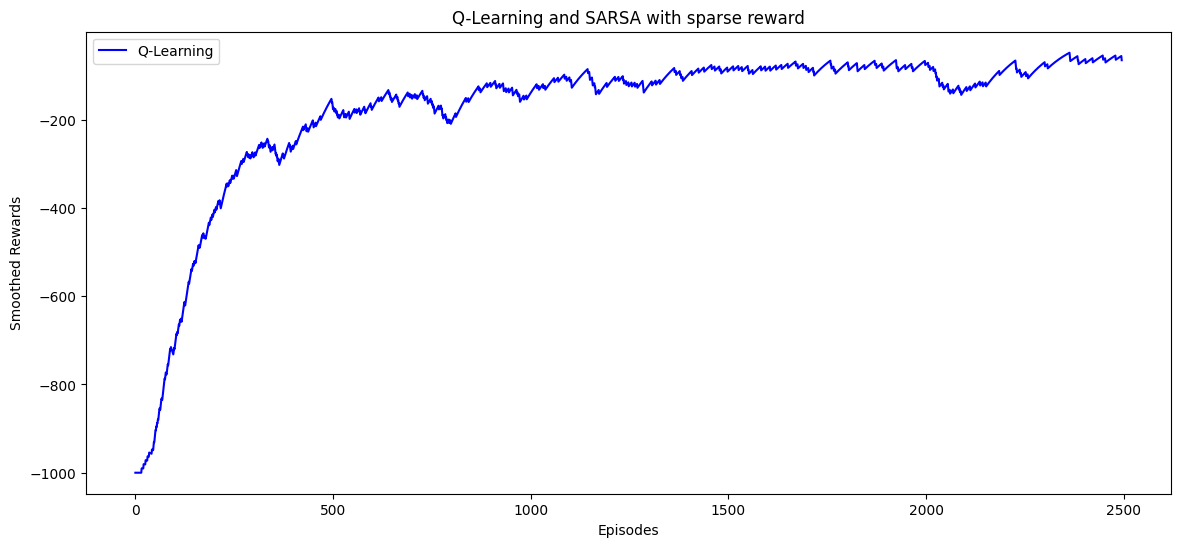

In [29]:
def plotgraph(weight,rewards):
  # Smooth plot
  last = rewards[0]
  smoothed = []
  for v in rewards:
      smoothed_val = last * weight + (1 - weight) * v
      smoothed.append(smoothed_val)
      last = smoothed_val
  return smoothed

def main():
    env = CliffBoxGridWorld()
    agentRL = RLAgent(env, num_episodes=2496,epsilon=0.012096065877324085, alpha=0.6883185189590643, gamma=0.9882245846605997)
    rewardsQL = agentRL.learn_sparseReward("QLearning")
    print(f"The maximum returns for\nQ-Learning: {max(rewardsQL)}   episode: {rewardsQL.index(max(rewardsQL))}")


    plt.figure(figsize=(14, 6))
    # Smooth plot Q-Learning
    weight = 0.99
    lastQL = rewardsQL[0]
    smoothedQL = []
    for v in rewardsQL:
        smoothed_val = lastQL * weight + (1 - weight) * v
        smoothedQL.append(smoothed_val)
        lastQL = smoothed_val

    # Plot the learning curve for Q-Learning
    plt.plot(smoothedQL, label='Q-Learning', color='blue')

    # Add labels and legend
    plt.xlabel('Episodes')
    plt.ylabel('Smoothed Rewards')
    plt.title('Q-Learning and SARSA with sparse reward')
    plt.legend()

    # Show the plot
    plt.show()


main()